# SpO2 test

get spo2 and R-curve regression parameters from spo2_calibration


## import module and declare function

In [49]:

import numpy as np
import matplotlib.pyplot as plt
import os,sys
import scipy.signal as signal
from scipy.interpolate import interp1d
import re
import pandas as pd
import math

plt.style.use('ggplot')
sys.path.insert(0, os.path.abspath('../lib'))

import sig_proc as sp
import file_read

import csv

# Normalize to mv
def value_trans(data):
    data = data*1.2/2097151.0
    return data


def RMS_amp(data):
    squaredData = []
    for val in data:
        squaredData.append(val**2)
    
    ms = np.mean(squaredData)
    rms = math.sqrt(ms)
    return rms


# currently for 4 seconds version
def signalQuality(filt_R, filt_IR, sr):
    tm_length=2*sr
    template_R = filt_R[0:tm_length]
    template_IR = filt_IR[0:tm_length]
    test_signal_R = filt_R[tm_length:]
    test_signal_IR = filt_IR[tm_length:]

    r_xcorr = sqi_xcorr(test_signal_R, template_R)
    ir_xcorr = sqi_xcorr(test_signal_IR, template_IR)
    ri_corr = sp.corrcoef(test_signal_R, test_signal_IR)

    if r_xcorr <0.4 or ir_xcorr<0.4 or ri_corr < 0.6:
        level = 'low'
    elif (r_xcorr > 0.4 and r_xcorr <0.6) or (ir_xcorr > 0.4 and ir_xcorr<0.6):
        level = 'medium'
    else:
        level='high'
        
    return level


def sqi_xcorr(x,y):
    x_norm = sp.z_score(x)
    y_norm = sp.z_score(y)
    pxy = max(np.correlate(x_norm, y_norm))
#     pyy = np.correlate(y_norm, y_norm)
    pyy = sum(y_norm*y_norm)
    return (2*pxy)/pyy



def ppg_proc(df, index, sr=50):
    global bp_a, bp_b
    
    for i in index:
        subject = df.loc[i]['subject']
        data = file_read.thor2_reader(os.path.join("../../data", folder, subject))

        R = np.array(data['PPG_R'])
        IR = np.array(data['PPG_IR'])
        G = np.array(data['PPG_G2'])

        
        s1 = df.loc[i]['t1']*sr
        s2 = s1+6*sr
        IR_segment = np.array(IR[s1:s2])
        R_segment = np.array(R[s1:s2])
        G_segment = np.array(G[s1:s2])
        
        filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
        filt_R = signal.filtfilt(bp_b, bp_a, R_segment)
        filt_G = signal.filtfilt(bp_b, bp_a, G_segment)
        
        
        R_AC = RMS_amp(filt_R)
        IR_AC = RMS_amp(filt_IR)
        
        plt.figure(figsize=(6,4))

        # plt.axhline(R_AC, color='r', linestyle='--')
        # plt.axhline(IR_AC, color='blue', linestyle='--')
        
        plot_title = "{}, {} \n".format(subject, df.loc[i]['t1'])
        plot_title = plot_title + "R-value: {}\n".format(np.round(df.loc[i]['R_value'],2))
        plt.title(plot_title)
        plt.plot(filt_R, label='R')
        
        
        plt.plot(filt_IR, label='IR')
        # plt.plot(filt_G, label='G')
        plt.legend()




## Main function

In [39]:

# folder = 'SPO2'
# subjects = ['Jet', 'Nicole']

folder = "Thor 2.0 BP收集 1220-0103"
subjects = ['Coco', 'Gary', 'Jack', 'Molly', 'Nicole', 'Rick', 'Shawn', 'Steven', 'Vanessa']
# subjects = ['Tanya']
days = ['01','02', '03']
days = ['01'] # recored 5 day 01, 02, 03, 04, 05
meridiem = 'PM'


''' Select the duration of PPG segment in seconds'''
start_sec = 0
period = 4
overlap = 2
# overlap = 0
# data_length = len(G_y)/sr
hop_length = period - overlap
# num_watching_period = 5
# num_watching_period = int((data_length - overlap)/hop_length) -1

vsTable = {
    'subject':[],
    'spo2':[],
    'R_AC':[],
    'R_DC':[],
    'IR_AC':[],
    'IR_DC':[],
    'G_AC':[],
    'G_DC':[],
    'R_value':[],
    'R_squared':[],
    'quality':[]
}
sr = 50

# Filter parameters
bp_b, bp_a = sp.bp_filter(0.8, 3, sr, 4)
lp_b, lp_a = sp.lp_filter(3, sr, 4)

# K1 = 121.12
# K2 = -51.77
coeficient = [-12.75886139, 1.39192419]
intercept = 104.14801275562009
for day in days:
    for subject in subjects:
        full_path = os.path.join("../../data", folder, subject, day, meridiem)
        # data = file_read.thor2_reader(os.path.join("../../data", folder, subject), 'RawData')
        R = file_read.load_ppg(full_path, 'PPG_R')
        IR = file_read.load_ppg(full_path, 'PPG_IR')
        G = file_read.load_ppg(full_path, 'PPG_G')
        # R = data['PPG_R']
        # IR = data['PPG_IR']
        # G = data['PPG_G2']
        R = np.array(list(map(value_trans, R)))
        IR = np.array(list(map(value_trans, IR)))
        G = np.array(list(map(value_trans, G)))

            
        
        data_length = len(G)/sr
        num_watching_period = int((data_length - start_sec -overlap)/hop_length) -1
        # num_watching_period = 3

        per_spo2 = []
        per_R = []
        for n in range(num_watching_period):
            

            t1 = start_sec +  (period-overlap) * n
            t2 = t1 + period
            s1 = int(t1*sr)
            s2 = int(t2*sr )

            '''''''''''''''''''''''''''''''''''''''
            Signal Preprocessing
            '''''''''''''''''''''''''''''''''''''''
            IR_segment = np.array(IR[s1:s2])
            R_segment = np.array(R[s1:s2])
            G_segment = np.array(G[s1:s2])
            
            ''' AC component '''
            filt_IR = signal.filtfilt(bp_b,bp_a, IR_segment)
            filt_R = signal.filtfilt(bp_b, bp_a, R_segment)
            filt_G = signal.filtfilt(bp_b, bp_a, G_segment)
            ''' DC component '''
            R_DC_component = signal.filtfilt(lp_b,lp_a, R_segment)
            IR_DC_component = signal.filtfilt(lp_b,lp_a, IR_segment)
            G_DC_component = signal.filtfilt(lp_b,lp_a, G_segment)

            ''' signal quality '''
            level = signalQuality(filt_R, filt_IR, sr)
            
            ''' Calculate R value by using RMS method'''
            R_AC = RMS_amp(filt_R)
            R_DC = RMS_amp(R_DC_component)
            IR_AC = RMS_amp(filt_IR)
            IR_DC = RMS_amp(IR_DC_component)
            
            G_AC = RMS_amp(filt_G)
            G_DC = RMS_amp(G_DC_component)
            
            R_RMS = R_AC/R_DC
            IR_RMS = IR_AC/IR_DC
            
            # R_divide = filt_R/R_DC_component
            # R_RMS = RMS_amp(R_divide)

            # IR_divide = filt_IR/IR_DC_component
            # IR_RMS = RMS_amp(IR_divide)
            
            R_value = R_RMS/ IR_RMS
            R_squared = R_value**2
            
            spo2 = intercept + (coeficient[0]*R_value) + (coeficient[1]*R_squared)

            # simulator
            # spo2 = 119.4638 + (-37.8709*R_value) + (-0.1610*R_squared)
            
            vsTable['subject'].append(subject)
            vsTable['quality'].append(level)
            vsTable['spo2'].append(spo2)
            vsTable['R_AC'].append(R_AC)
            vsTable['R_DC'].append(R_DC)
            vsTable['IR_AC'].append(IR_AC)
            vsTable['IR_DC'].append(IR_DC)
            vsTable['G_AC'].append(G_AC)
            vsTable['G_DC'].append(G_DC)
            # vsTable['R_PI'].append(R_RMS)
            # vsTable['IR_PI'].append(IR_RMS)
            vsTable['R_value'].append(R_value)
            vsTable['R_squared'].append(R_squared)
            
            '''''''''''''''''''''''''''''''''''
            plot filgure
            '''''''''''''''''''''''''''''''''''
            font_size = 14
            fig_size  = (6,4)
            
            
            
            # plt.figure(figsize=fig_size)
            # plot_title = "{},{}:{}, quality:{} \n".format(subject, t1,t2, level)
            # plot_title = plot_title + "spo2: {}\n".format(np.round(spo2,2))
            # plt.title(plot_title)
            # plt.plot(filt_R, label='R')
            # plt.plot(filt_IR, label='IR')
            # plt.legend()
            per_R.append(R_value)
            per_spo2.append(spo2)




## Create dataframe for vital sign

In [40]:
df = pd.DataFrame(vsTable)
df.head()

,subject,spo2,R_AC,R_DC,IR_AC,IR_DC,G_AC,G_DC,R_value,R_squared,quality
0,Coco,94.067730,0.000128,0.668059,0.000165,0.752154,0.000779,0.503269,0.873254,0.762572,low
1,Coco,91.528733,0.000248,0.668927,0.000247,0.750615,0.000910,0.496823,1.127828,1.271996,low
2,Coco,91.589438,0.000233,0.669477,0.000232,0.749842,0.000795,0.494974,1.121523,1.257814,high
3,Coco,97.037660,0.000077,0.669437,0.000146,0.749879,0.000698,0.497854,0.596046,0.355270,low
4,Coco,97.487888,0.000062,0.669018,0.000126,0.749853,0.000670,0.502405,0.555687,0.308788,low


## Select specific subject to display R-value distribution

Text(0, 0.5, 'spo2')

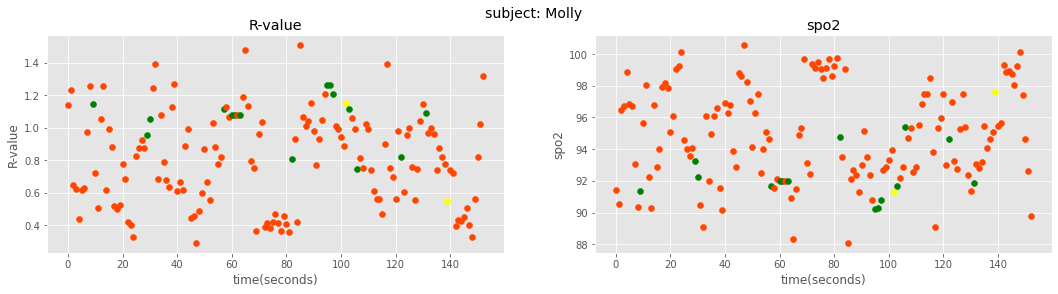

In [42]:


tartgetSub = subjects[3]
subjectDF = df[df.subject ==tartgetSub]

dflen = len(subjectDF.index)
time_axis = np.arange(0,dflen*2, 2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4),  gridspec_kw={'width_ratios': [1, 1]})
fig.suptitle('subject: ' + tartgetSub, size=14)

t=0
smoothR = []
smooth_len = 5
for i in subjectDF.index:        
    if t >= smooth_len:
        smoothR.append(subjectDF['R_value'][i-smooth_len:i])
    if subjectDF['quality'][i] =='high':
        ax1.scatter(t, subjectDF['R_value'][i], color='green')
        ax2.scatter(t, subjectDF['spo2'][i], color='green')

    elif subjectDF['quality'][i] =='medium':
        ax1.scatter(t, subjectDF['R_value'][i], color='yellow')
        ax2.scatter(t, subjectDF['spo2'][i], color='yellow')
    else:
        ax1.scatter(t, subjectDF['R_value'][i], color='orangered')
        ax2.scatter(t, subjectDF['spo2'][i], color='orangered')
    t+=1
    
    
ax1.set_title('R-value')
ax1.set_xlabel('time(seconds)')
ax1.set_ylabel('R-value')


ax2.set_title('spo2')
ax2.set_xlabel('time(seconds)')
ax2.set_ylabel('spo2')






In [50]:
ppg_proc(subjectDF, subjectDF.index[0:30])

PermissionError: [Errno 13] Permission denied: '../../data\\Thor 2.0 BP收集 1220-0103\\Molly'

## box plot

In [ ]:

# box plot for R value
plt.figure()
plt.title(tartgetSub + ', R-value')
bp = plt.boxplot(subjectDF.R_value, showmeans=True)
# df.boxplot(column='R_value')
print([item.get_ydata() for item in bp['boxes']])

## Training new R curve (combine )

Model coeficient:     [ 17.41863831 -18.27211895]
Model intercept: 94.81588110236386


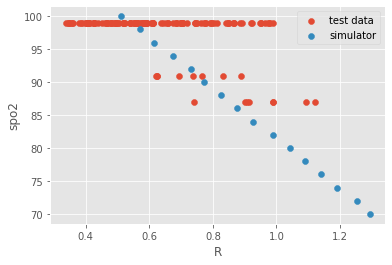

In [205]:
plt.scatter(df3.R_value, df3.spo2, label='test data')
plt.scatter(reg_x, reg_y, label='simulator')
plt.xlabel('R')
plt.ylabel('spo2')
plt.legend()

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

# X = np.array([[df.R_value, df.R_squared]])
X=df3[['R_value', 'R_squared']]
model.fit(X, df3.spo2)

# xfit = np.linspace(0, 10, 100)
# yfit = model.predict(xfit[:, np.newaxis])

# plt.scatter(x, y)
# plt.plot(xfit, yfit);

print("Model coeficient:    ", model.coef_)
print("Model intercept:", model.intercept_)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


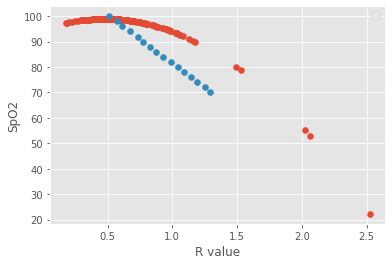

In [199]:
plt.figure()
plt.scatter(df.R_value, df.spo2)

plt.scatter(reg_x, reg_y)

plt.xlabel("R value")
plt.ylabel("SpO2")
plt.legend()

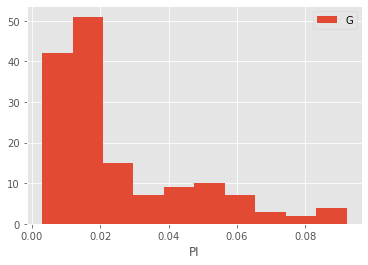

In [208]:
# df['R_PI'] = (df['R_AC']/df['R_DC'])*100
# df['IR_PI'] = (df['IR_AC']/df['IR_DC'])*100
df['G_PI'] = (df['G_AC']/df['G_DC'])*10
plt.hist(df.G_PI, density=False, cumulative = False, label='G')
plt.legend()
plt.xlabel('PI')
plt.show()